<a href="https://colab.research.google.com/github/iamvarada/colab_ML/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
## Transfer learning - reuse a trained model thats been trained on large datasets to achieve higher accuracy

# We will use MobileNet model. - model by Google trained on ImageNet
# ImageNet has 1000 labels, cats and dogs have 2 labels.
# We will use MobileNet to train for cats and dogs dataset (aka trasnsfer learning)

# Tensofrflow hub is a library of all the pre-trained models

# Defs: 
# Freezing parameters: setting the variables of a pre-trained model to be non-trainable
# This ensures that only the variables of the last (or last few) layers that we add are trained


In [4]:
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [5]:
# Download the classifier (model - MobileNet V2)

CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224 # image resolution expected by MobileNet

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

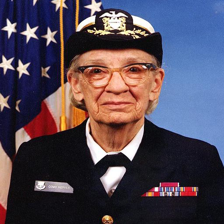

In [6]:
# Download an image to run MobileNet on
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES)) # re-size to have same size as input expected by MobileNet
grace_hopper 

In [7]:
grace_hopper = np.array(grace_hopper)/255.0 # normalization
grace_hopper.shape

(224, 224, 3)

In [8]:
# Predict/Infer the input image using MobileNet
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape # 1 image with PDF of 1001 classes as ImageNet has 1001 classes and we are only giving 1 input image

1/1 [==============================] - 7s 7s/step


(1, 1001)

In [9]:
predicted_class = np.argmax(result[0], axis = -1)
predicted_class

653

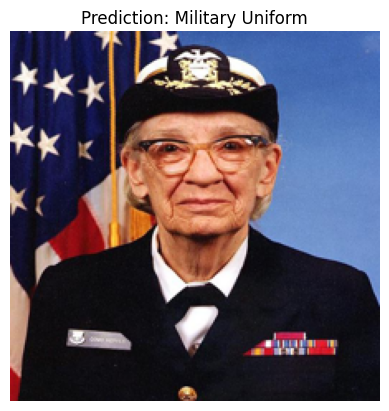

In [10]:
# Check what the prdicted class means by using the ImageNet data

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [11]:
## Now run MobileNet on cats and dogs dataset

# Loading the dataset

(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [12]:
# Images are of diff. sizes, hence re-size to the MobileNet size
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1) # shuffle, batch size
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)


In [13]:
# Predict

image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names # MobileNet seem to indeed predict the class labels of cats and dogs, but we dont get the labels (cats vs dogs)

1/1 [==============================] - 1s 712ms/step


array(['dalmatian', 'redbone', 'Egyptian cat', 'Great Dane',
       'Egyptian cat', 'Great Dane', 'Rhodesian ridgeback',
       'American Staffordshire terrier', 'Persian cat', 'affenpinscher',
       'Egyptian cat', 'Labrador retriever', 'Airedale',
       'German short-haired pointer', 'German shepherd', 'Egyptian cat',
       'Siberian husky', 'tabby', 'Persian cat', 'tabby',
       'Labrador retriever', 'tabby', 'Egyptian cat', 'Egyptian cat',
       'Labrador retriever', 'beagle', 'groenendael', 'tabby',
       'Egyptian cat', 'American Staffordshire terrier', 'Egyptian cat',
       'Border collie'], dtype='<U30')

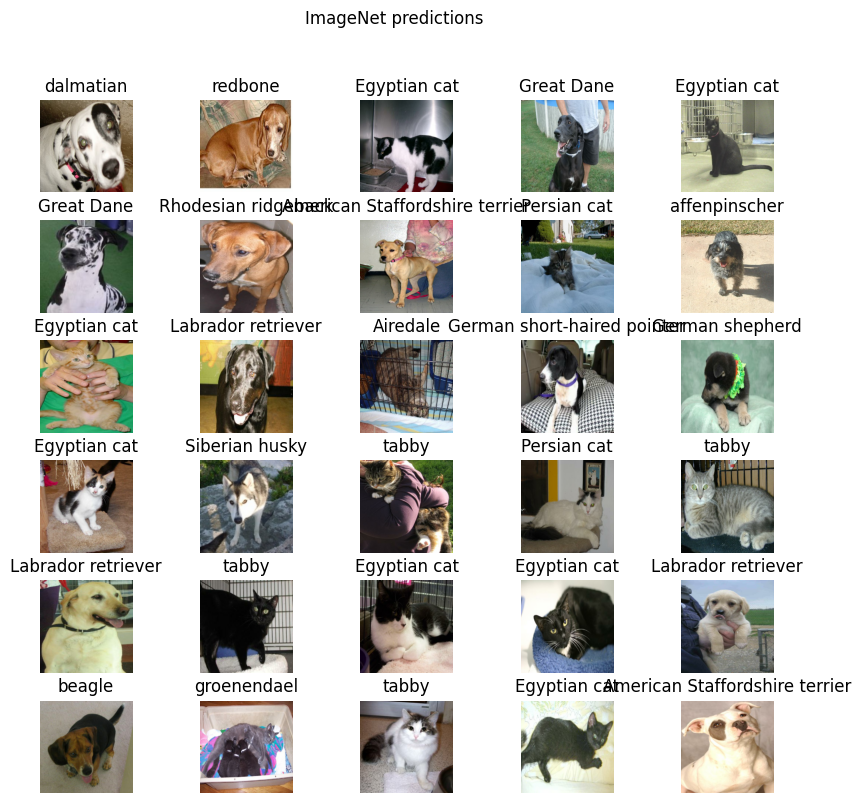

In [14]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [15]:
## Transfer learning with Tensorflow hub

URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
# So most of the work is done but not all
feature_extractor = hub.KerasLayer(URL, # "feature extractor" as this model does not have the last output layer but everything else from that model
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [16]:
# feed images into this model

feature_batch = feature_extractor(image_batch)
print(feature_batch.shape) ## 1280 is different from 1001 as the final layer is cutoff

(32, 1280)


In [17]:
# set the feature_extractor to be non-trainable as we only train the layers that we add 

feature_extractor.trainable = False

In [18]:
# Attach our own classificaiton head

model = tf.keras.Sequential([
    feature_extractor, # all layers from MobileNet except the last one
    layers.Dense(2, activation='softmax') # last classifcation layer for our cats vs dogs output (2 labels)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [19]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
    )

EPOCHS = 3
history = model.fit(train_batches,
                    epochs = EPOCHS,
                    validation_data = validation_batches
                    )

# We achieve a very high accuracy just by using a pre-trained model and adding our classification layer

Epoch 1/3
582/582 [==============================] - 58s 83ms/step - loss: 0.0544 - accuracy: 0.9810 - val_loss: 0.0507 - val_accuracy: 0.9832
Epoch 2/3
582/582 [==============================] - 72s 113ms/step - loss: 0.0326 - accuracy: 0.9883 - val_loss: 0.0291 - val_accuracy: 0.9899
Epoch 3/3
582/582 [==============================] - 56s 85ms/step - loss: 0.0259 - accuracy: 0.9912 - val_loss: 0.0306 - val_accuracy: 0.9897


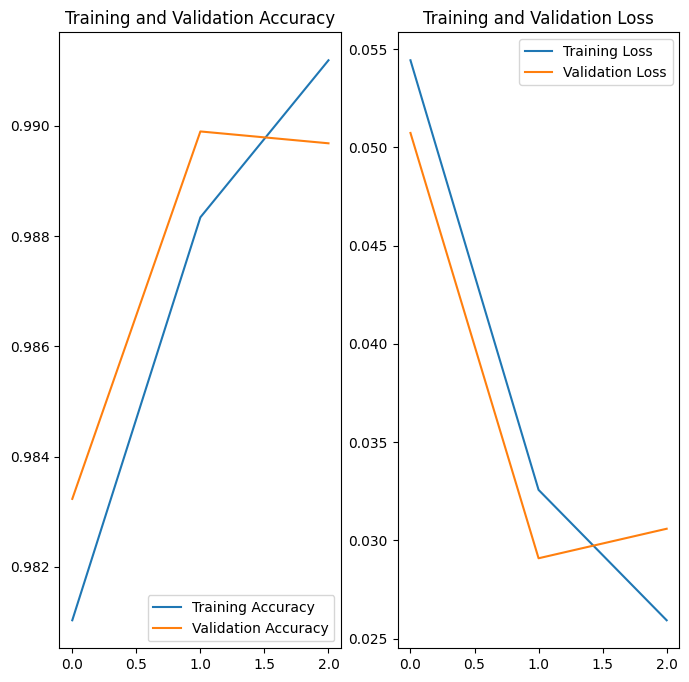

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
# Check predictions

class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [22]:
# run the image batch through the model and convert the indices to class names

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis = -1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

1/1 [==============================] - 0s 491ms/step


array(['dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat',
       'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat',
       'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat',
       'cat', 'cat', 'dog', 'cat', 'dog'], dtype='<U3')

In [23]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1]
Predicted labels:  [1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1]
